<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Autoencoders


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
import pandas as pd  ##
from torch.autograd import Variable
from torchvision import datasets
import torchvision.transforms as tfs
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
import os  ##
from skimage.io import imread  ##
from skimage.transform import resize  ##
from IPython.display import clear_output

In [ ]:
## буду сохранять данные на гуглдрайве
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
## функция для считывания данных
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    # mass-merge
    # (photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    # image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img: img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
# from get_dataset import fetch_dataset
data, attrs = fetch_dataset()  ##

In [ ]:
data.shape  ##

(13143, 64, 64, 3)

In [ ]:
## данные у нас "даблы" - преобразуем их в обычный "флоат"
data = data.astype(np.float32, copy=False)

In [ ]:
data.dtype

dtype('float32')

In [ ]:
attrs.sample(10)

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
5254,1.485423,1.946471,-1.159121,-2.423385,-1.399407,-0.735594,-0.391629,-0.781185,-0.428419,0.677976,...,0.849578,-0.256163,-0.502093,-1.217076,-2.931601,-0.756783,2.122794,-0.938406,0.566799,-1.340491
3127,1.262036,-2.394262,2.46926,-2.486763,-2.269548,-1.362774,-0.323738,-0.400444,-1.304435,0.067336,...,-0.883833,0.478067,-0.270465,-0.563407,2.520934,-0.574916,-0.115117,-0.507461,-0.096066,0.186737
12354,1.936025,-1.541153,1.228419,-1.441619,-2.069279,-0.938761,-0.871309,0.173899,-0.738329,-1.114868,...,1.183204,-0.185876,0.618456,-1.989023,-2.77037,-0.881212,-1.06315,-1.228231,1.272784,-0.884678
9755,-1.699824,-1.682982,1.014486,-1.333194,-2.003616,-1.291272,0.534868,-0.69406,-0.747663,-2.03183,...,-0.989655,-2.296225,1.594835,1.366675,-2.530246,1.609532,1.21042,0.37841,-0.428595,0.732494
3063,1.82472,-1.933782,2.299214,-1.745689,-2.284775,-1.533541,-1.704223,-0.33138,0.825511,-1.961627,...,-1.048044,-0.612185,1.414361,-1.615765,-0.936236,-0.418224,0.193222,-0.509082,1.434413,-1.139652
126,0.805509,-1.418606,0.467993,-2.261561,-2.982557,-0.231483,-1.194969,-0.626129,0.169157,-1.746622,...,0.295826,-0.701132,0.82392,-1.187755,-2.787156,0.014776,0.115347,-0.756749,0.297467,-0.790053
10355,0.911402,-1.5886,1.31483,-2.145222,-1.951134,-1.544846,-1.209023,-0.1511,-0.000326,-0.701984,...,0.697269,0.873094,0.147524,-1.823392,0.039863,-0.26289,-0.451391,-0.840986,0.634605,-0.731389
2072,0.846212,-1.540366,-1.697683,-0.097613,-1.817375,-1.172728,-1.053376,-0.207418,-0.469008,0.241723,...,-2.435765,0.093605,0.052784,-0.463268,0.028196,0.27195,1.016053,-0.182253,0.176434,-0.559501
1150,0.620103,-0.780434,0.385004,-1.029543,-0.783662,-0.58571,-1.210961,-0.601451,0.047927,-1.915215,...,-0.139185,-1.307387,-0.300044,-0.403294,-2.971977,-0.736375,1.3277,-0.737181,0.581914,-0.455513
5195,0.94026,0.979692,-0.98894,-3.353191,-3.190921,-0.254254,0.654466,-0.429511,-1.552055,-0.73222,...,1.214608,-0.881096,-0.757881,-0.70527,-1.61792,-0.285439,0.728765,-0.2248,0.006791,-0.484603



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
## <тут Ваш код>

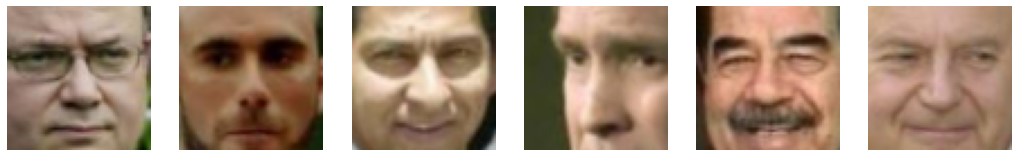

In [ ]:
## 6 случайных картинок
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.axis("off")
    plt.imshow(data[np.random.randint(data.shape[0])])
plt.show();

In [ ]:
## из 13143 индексов выбираем случайно все и делим их по границe ~80% - 10500
ix = np.random.choice(data.shape[0], data.shape[0], False)
tr, vl = np.split(ix, [10500])

In [ ]:
tr.shape, vl.shape

((10500,), (2643,))

In [ ]:
batch_size = 25
## размерность №3, которую мы делаем №1, это три цвета
data_tr = data_utils.DataLoader(list(np.rollaxis(data[tr], 3, 1)), 
                                batch_size=batch_size, shuffle=True)
data_val = data_utils.DataLoader(list(np.rollaxis(data[vl], 3, 1)),
                                batch_size=batch_size, shuffle=True)

In [ ]:
data_tr, data_val

(<torch.utils.data.dataloader.DataLoader at 0x7f0441968310>,
 <torch.utils.data.dataloader.DataLoader at 0x7f0512754ad0>)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64  ## <your code here> # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
## попробуем реализовать на свертках
class Autoencoder(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder>
        super().__init__()

        ## 64 -> 32
        self.en0 = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU())
        
        ## 32 -> 16
        self.en1 = nn.Sequential(
                      nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU())
        
        ## 16 -> 8
        self.en2 = nn.Sequential(
                      nn.Conv2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU())
        
        ## 16*8*8 -> 1*1024 -> 1*64
        self.lin = nn.Sequential(
                      nn.Flatten(),
                      nn.Sigmoid(),
                      nn.Linear(in_features=16*8*8, out_features=dim_code))

        ## 1*64 -> 8*8 -> 16*16
        self.dc0 = nn.Sequential(
                      nn.Unflatten(1, (1, 8, 8)),
                      nn.ConvTranspose2d(1, 16, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(16),
                      nn.ReLU())
        
        ## 16 -> 32
        self.dc1 = nn.Sequential(
                      nn.ConvTranspose2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(32),
                      nn.ReLU())
        ## 32 -> 64
        self.dc2 = nn.Sequential(
                      nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU())
        
        ## 64*64*64 -> 3*64*64
        self.dc3 = nn.Sequential(
                      nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1, bias=False),
                      nn.Tanh())


    def forward(self, x):
        ## 
        '''<реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)>'''
        x = self.en0(x)
        x = self.en1(x)
        x = self.en2(x)
        latent_code = self.lin(x)
        x = self.dc0(latent_code)
        x = self.dc1(x)
        x = self.dc2(x)
        reconstruction = self.dc3(x)
        
        return reconstruction, latent_code

    def sample(self, z):
        ## получает латентный вектор и генерирует изображения
        generated = self.dc0(z)
        generated = self.dc1(generated)
        generated = self.dc2(generated)
        generated = self.dc3(generated)
        return generated

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    
    X_val_view = next(iter(data_val))
    ## загружаем один батч из валидации для отображения одних картинок

    for epoch in range(epochs):
        
        ## подсчет тренировочного лосса
        avg_train_loss = 0
        model.train()
        for X_batch in data_tr:
            X_batch = X_batch.to(device)

            opt.zero_grad()

            # forward
            X_pred = model(X_batch)
            loss = loss_fn(X_pred[0], X_batch)
            loss.backward()
            opt.step()

            avg_train_loss += loss / len(data_tr)

        train_losses.append(avg_train_loss.item())

        ## данные для вывода картинок
        model.eval()
        with torch.set_grad_enabled(False):
            X_hat = model(X_val_view.to(device))
        X_hat = X_hat[0].detach().cpu()

        ## считаем валидационные лоссы
        avg_val_loss = 0
        for X_batch in data_val:
            X_batch = X_batch.to(device)

            with torch.set_grad_enabled(False):
                X_pred = model(X_batch)
                loss = loss_fn(X_pred[0], X_batch)

            avg_val_loss += loss / len(data_val)
        
        val_losses.append(avg_val_loss.item())

        ## выводим 6 исходных картинок и 6 "автоэнкоженных"
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val_view[k].numpy(), 0, 3))
            plt.title('Original')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(np.rollaxis(X_hat[k].numpy(), 0, 3))
            plt.title('New')
            plt.axis('off')

        plt.suptitle(f'Эпоха: {epoch + 1}, train_loss: {train_losses[-1]}, val_loss: {val_losses[-1]}')
        plt.show()

    ## return train_losses, val_losses  ## у меня они глобальные

In [ ]:
## рисователь графиков
def make_charts(train_losses, val_losses):
    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()

In [ ]:
summary(autoencoder, (3, 64, 64), batch_size=batch_size)
# autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [25, 64, 32, 32]           3,072
       BatchNorm2d-2           [25, 64, 32, 32]             128
              ReLU-3           [25, 64, 32, 32]               0
            Conv2d-4           [25, 32, 16, 16]          32,768
       BatchNorm2d-5           [25, 32, 16, 16]              64
              ReLU-6           [25, 32, 16, 16]               0
            Conv2d-7             [25, 16, 8, 8]           8,192
       BatchNorm2d-8             [25, 16, 8, 8]              32
              ReLU-9             [25, 16, 8, 8]               0
          Flatten-10                 [25, 1024]               0
          Sigmoid-11                 [25, 1024]               0
           Linear-12                   [25, 64]          65,600
        Unflatten-13              [25, 1, 8, 8]               0
  ConvTranspose2d-14           [25, 16,

In [ ]:
train_losses = []
val_losses = []

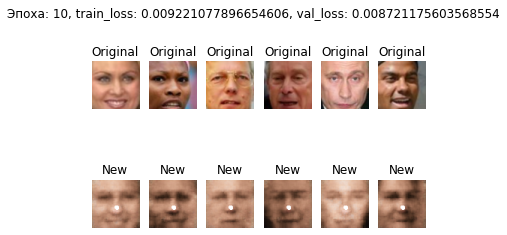

In [ ]:
## обучал с lr = 0.01
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-2, betas=(0.9, 0.99))
max_epochs = 10
train(autoencoder, optimizer, criterion, max_epochs, data_tr, data_val)

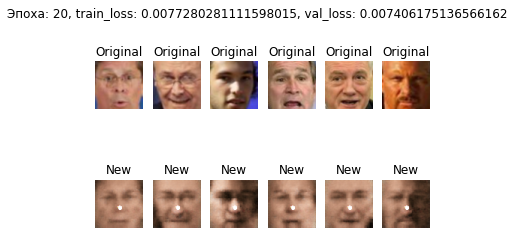

In [ ]:
## обучал с lr = 0.001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.9, 0.99))
max_epochs = 100
train(autoencoder, optimizer, criterion, max_epochs, data_tr, data_val)

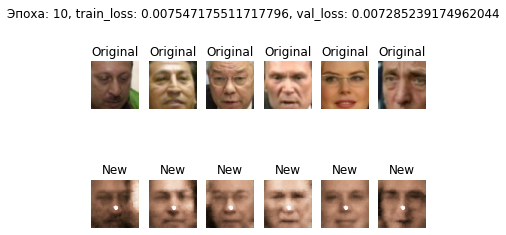

In [ ]:
## обучал с lr = 0.0001
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-4, betas=(0.9, 0.99))
max_epochs = 30
train(autoencoder, optimizer, criterion, max_epochs, data_tr, data_val)

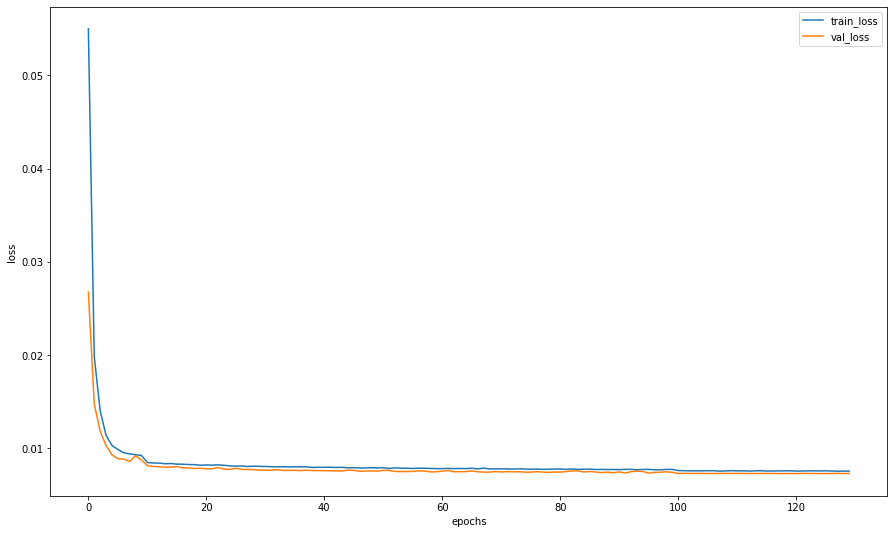

In [ ]:
 make_charts(train_losses, val_losses)

In [ ]:
## сохраню веса модели и лоссы

In [ ]:
torch.save(autoencoder.state_dict(), f'/content/gdrive/My Drive/autoencoder.pth')

In [ ]:
train_losses_ae, val_losses_ae = np.array(train_losses), np.array(val_losses)

In [ ]:
np.save('/content/gdrive/My Drive/train_losses_ae', train_losses_ae)
np.save('/content/gdrive/My Drive/val_losses_ae', val_losses_ae)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

In [ ]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
## делал ранее

Not bad, right? 

In [ ]:
## No :(

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
## загрузим модель
autoencoder = Autoencoder().to(device)
autoencoder.load_state_dict(torch.load('/content/gdrive/My Drive/autoencoder.pth', map_location=torch.device('cpu')))
autoencoder.eval()

Autoencoder(
  (en0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (en1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (en2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lin): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Sigmoid()
    (2): Linear(in_features=1024, out_features=64, bias=True)
  )
  (dc0): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1, 8, 8))
    (1): ConvTranspose2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): BatchNorm2

In [ ]:
## прогоним валидационную выборку и посчитаем среднее значение для латентного вектора

autoencoder.eval()
vector = np.array([0] * dim_code)

for X_batch in data_val:
    X_batch = X_batch.to(device)

    with torch.set_grad_enabled(False):
        X_pred = autoencoder(X_batch)
        vector = vector + X_pred[1].sum(axis=0).numpy()

vector /= vl.shape

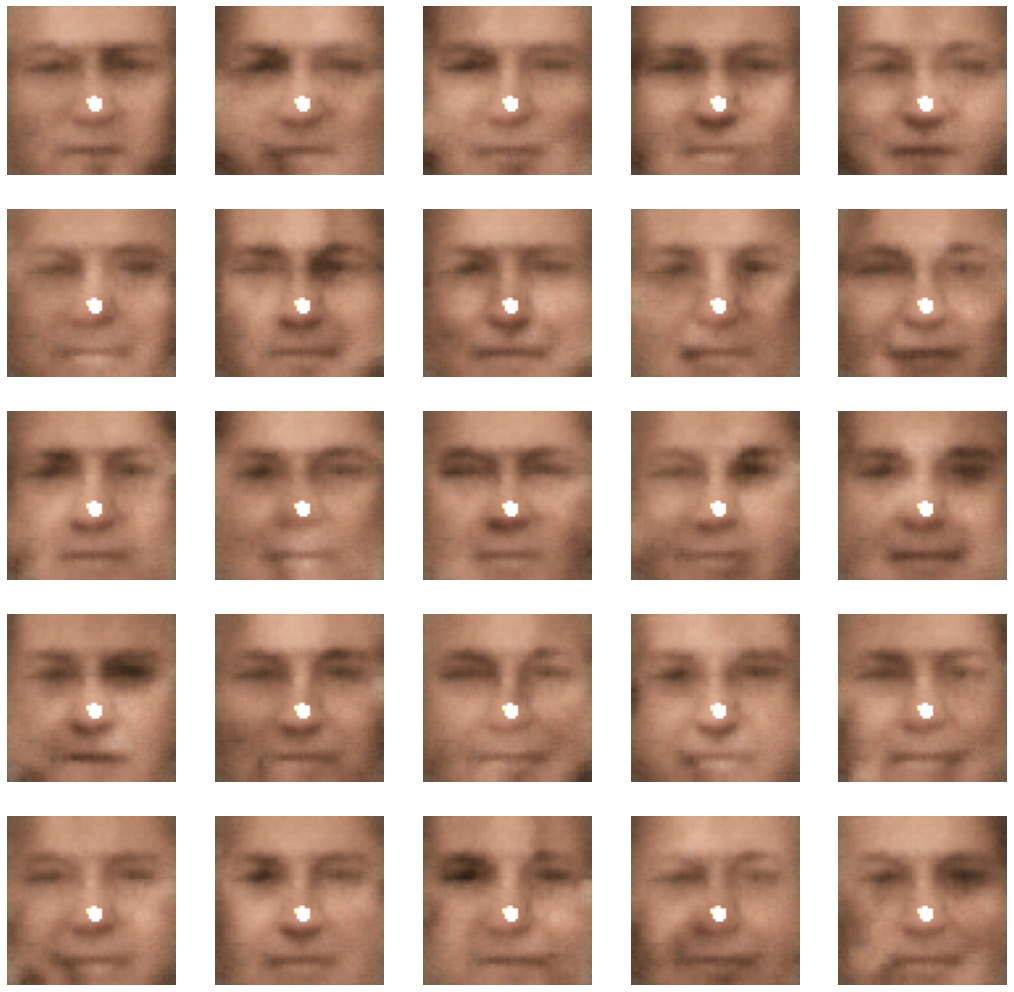

In [ ]:
##
# сгенерируем 25 рандомных векторов размера dim_code
z = np.random.randn(25, dim_code)
z = vector + 1 * z
z = torch.from_numpy(z).to(torch.float32)
output = autoencoder.sample(z)
## и сгенерируем изображения на их основе
plt.figure(figsize=(18, 18))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, 5 * i + j + 1)
        plt.imshow(np.rollaxis(output[5 * i + j].detach().numpy(), 0, 3))
        plt.axis('off')

plt.show()

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
<ваш код здесь>

In [ ]:
## отсортируем атрибуты по "улыбчивости"
## сохраним индексы самых улыбающихся и наоборот
## создадим загрузчики для этих изображений

In [ ]:
attrs_sorted = attrs.sort_values('Smiling')

In [ ]:
not_smile_indexes = attrs_sorted.Smiling.head(25).index
not_smile_indexes

Int64Index([11571,  1234,  7506,  5458,  7065, 11912,  1654,   471,  8410,
             8596, 12688,  1432, 10097, 10506,  9114,  6321,  3798,  8092,
             2390,  6019,  2529, 12298,  9201,  4392,  2000],
           dtype='int64')

In [ ]:
smile_indexes = attrs_sorted.Smiling.tail(25).index
smile_indexes

Int64Index([ 9755,  7941,  8247,   135, 12607, 12606,  1605,  9005,  9165,
              983,   682,  6166,   459,  9004,  1955,  2031,  1359, 11797,
             6139,  4681,  1045,  5624, 13034,  1816,  8643],
           dtype='int64')

In [ ]:
data_not_smile = data_utils.DataLoader(list(np.rollaxis(data[not_smile_indexes], 3, 1)), 
                                        batch_size=batch_size, shuffle=True)

In [ ]:
data_smile = data_utils.DataLoader(list(np.rollaxis(data[smile_indexes], 3, 1)), 
                                        batch_size=batch_size, shuffle=True)

In [ ]:
## посчитаем средний вектор неулыбчивого человека
autoencoder.eval()
not_smile_man = np.array([0] * dim_code)

for X_batch in data_not_smile:
    X_batch = X_batch.to(device)

    with torch.set_grad_enabled(False):
        X_pred = autoencoder(X_batch)
        not_smile_man = not_smile_man + X_pred[1].sum(axis=0).numpy()

not_smile_man /= batch_size

In [ ]:
## посчитаем средний вектор улыбчивого человека
autoencoder.eval()
smile_man = np.array([0] * dim_code)

for X_batch in data_smile:
    X_batch = X_batch.to(device)

    with torch.set_grad_enabled(False):
        X_pred = autoencoder(X_batch)
        smile_man = smile_man + X_pred[1].sum(axis=0).numpy()

smile_man /= batch_size

In [ ]:
## вычислим улыбку
smile = smile_man - not_smile_man
smile

array([ 1.32698364, -1.12248291,  1.79787109,  2.00283691,  2.10256104,
        1.44452637, -0.53057373, -2.51712891,  0.27443848, -1.07936279,
        2.06200684, -2.14220703,  2.68835449,  1.07952881,  2.39238525,
        2.16518921, -1.10169434,  0.33531738,  0.72759521,  2.9019043 ,
        1.77604248,  2.02099365,  0.59992188, -0.61485107,  2.25223145,
       -1.18036621,  0.63090576,  1.10188477,  0.3721814 , -0.01531494,
       -0.80355957,  0.33623047, -0.75349609, -3.38249023,  0.2476709 ,
        0.50320312,  1.9921582 , -1.47532715, -1.76453979,  1.43521729,
       -1.2919873 ,  1.99217041, -0.6999353 , -2.98287109,  1.50826782,
       -0.47802734, -4.00295898,  0.46506714, -3.46017334,  1.89890991,
        1.03284424, -3.67830383,  6.89088867,  3.59240845,  0.68201782,
       -0.84813477, -3.28277954,  0.43449219,  3.33411621,  1.86300293,
        3.60151855,  0.46134521,  4.00303223, -1.52897461])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


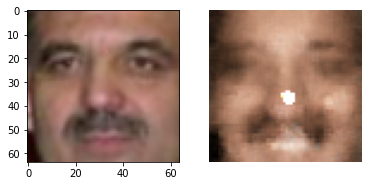

In [ ]:
## образец 
image = np.rollaxis(data[43], 2, 0)[np.newaxis, :, :, :]

## его латентный вектор + улыбка
z = autoencoder(torch.from_numpy(image))[1] \
    + torch.from_numpy(smile).to(torch.float32)
output = autoencoder.sample(z)

plt.subplot(1, 2, 1)
plt.imshow(np.rollaxis(image[0], 0, 3))
plt.subplot(1, 2, 2)
plt.imshow(np.rollaxis(output.detach().numpy()[0], 0, 3))
plt.axis('off')

plt.show()

Вуаля! Вы восхитительны!

In [ ]:
## еще и издеваются...

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=tfs.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=tfs.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_code = 2
class VAE(nn.Module):
    def __init__(self):
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, dim_code * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 16),
            nn.ReLU(),
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        """<реализуйте forward проход энкодера
        в качестве возвращаемых переменных -- mu и logsigma>"""
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, dim_code)
        # print(f'латентный вектор: {x[0].tolist()}')
        ## из 4 значений делаем 2 вектора по 2 значения: мю и логвары
        mu = x[:, 0, :] ## первые 2 значения
        logsigma = x[:, 1, :] ## вторые два
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            """<засемплируйте латентный вектор из нормального 
            распределения с параметрами mu и sigma>"""
            ## хотим нормальное распределение (0, 1) сместить так, 
            ## чтобы распределение имело параметры mu и log_var
            std = torch.exp(0.5 * logsigma)  ## стандартное отклонение
            ## генерируем случайную нормальную последовательность 
            ## той же размерности, что и std:
            eps = torch.randn_like(std)
            ## получаем случайные значения смещаясь от средних на eps * std
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        reconstruction = self.decoder(z)

        return reconstruction

    def forward(self, x):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- mu, logsigma и reconstruction>"""

        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)

        return mu, logsigma, reconstruction.view(-1, 1, 28, 28)

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
##
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    # loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    # print(f'KL-loss: {loss.item()}')
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')  # <binary cross-entropy>
    loss = loss(reconstruction.view(-1, 784), x.view(-1, 784))
    # print(f'lh-loss: {loss.item()}')
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)
    # <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    
    X_val_view = next(iter(data_val))[0]
    ## загружаем один батч из валидации для отображения одних картинок

    for epoch in range(epochs):
        
        ## подсчет тренировочного лосса
        avg_train_loss = 0
        model.train()
        for X_batch in data_tr:
            X_batch = X_batch[0].to(device)

            opt.zero_grad()

            # forward
            mu, logsigma, X_pred = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)
            loss.backward()
            opt.step()

            avg_train_loss += loss / len(data_tr)

        train_losses.append(avg_train_loss.item())

        ## данные для вывода картинок
        model.eval()
        with torch.set_grad_enabled(False):
            _, _, X_hat = model(X_val_view.to(device))
        X_hat = X_hat.detach().cpu()

        ## считаем валидационные лоссы
        avg_val_loss = 0
        for X_batch in data_val:
            X_batch = X_batch[0].to(device)

            with torch.set_grad_enabled(False):
                mu, logsigma, X_pred = model(X_batch)
                loss = loss_fn(X_batch, mu, logsigma, X_pred)

            avg_val_loss += loss / len(data_val)
        
        val_losses.append(avg_val_loss.item())

        ## выводим 6 исходных картинок и 6 "автоэнкоженных"
        ## plt.imshow умеет только форматы 28*28, 28*28*3, 28*28*4
        ## поэтому X_val_view[k][0] (он имеет размерность 1*28*28)
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(X_val_view[k][0].numpy())
            plt.title('Original')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(X_hat[k][0].numpy())
            plt.title('New')
            plt.axis('off')

        plt.suptitle(f'Эпоха: {epoch + 1}, train_loss: {train_losses[-1]}, val_loss: {val_losses[-1]}')
        plt.show()

In [ ]:
## рисователь графиков
def make_charts(train_losses, val_losses):
    plt.figure(figsize=(15, 9))
    plt.plot(train_losses, label="train_loss")
    plt.plot(val_losses, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
criterion = loss_vae

autoencoder_vae = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0) 
# <Ваш любимый оптимизатор>

In [ ]:
summary(autoencoder_vae, (1, 28, 28), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [32, 784]               0
            Linear-2                  [32, 128]         100,480
              ReLU-3                  [32, 128]               0
            Linear-4                   [32, 16]           2,064
              ReLU-5                   [32, 16]               0
            Linear-6                    [32, 4]              68
            Linear-7                   [32, 16]              48
              ReLU-8                   [32, 16]               0
            Linear-9                  [32, 128]           2,176
             ReLU-10                  [32, 128]               0
           Linear-11                  [32, 784]         101,136
          Sigmoid-12                  [32, 784]               0
Total params: 205,972
Trainable params: 205,972
Non-trainable params: 0
-------------------------------

In [ ]:
# <обучите модель на датасете MNIST>

In [ ]:
train_losses = []
val_losses = []

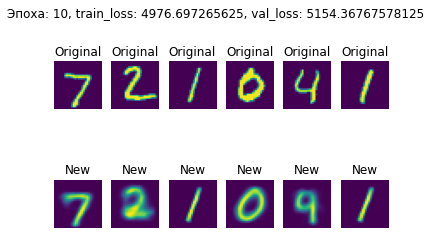

In [ ]:
max_epochs = 10
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0)
train(autoencoder_vae, optimizer, criterion, max_epochs, train_loader, test_loader)

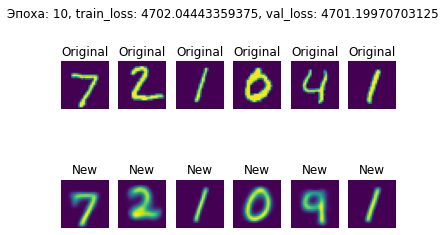

In [ ]:
max_epochs = 20
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0)
train(autoencoder_vae, optimizer, criterion, max_epochs, train_loader, test_loader)

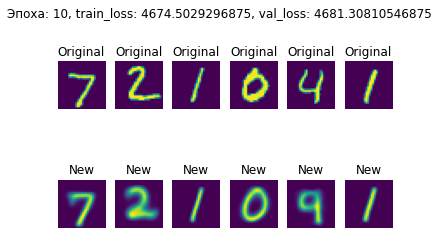

In [ ]:
max_epochs = 10
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0)
train(autoencoder_vae, optimizer, criterion, max_epochs, train_loader, test_loader)

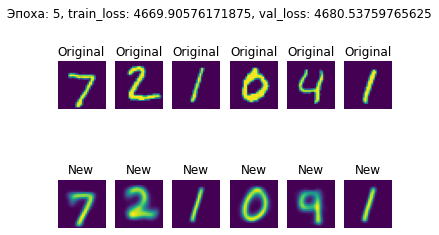

In [ ]:
max_epochs = 5
optimizer = torch.optim.Adam(autoencoder_vae.parameters(), lr=0.00001, betas=(0.9, 0.999), weight_decay=0)
train(autoencoder_vae, optimizer, criterion, max_epochs, train_loader, test_loader)

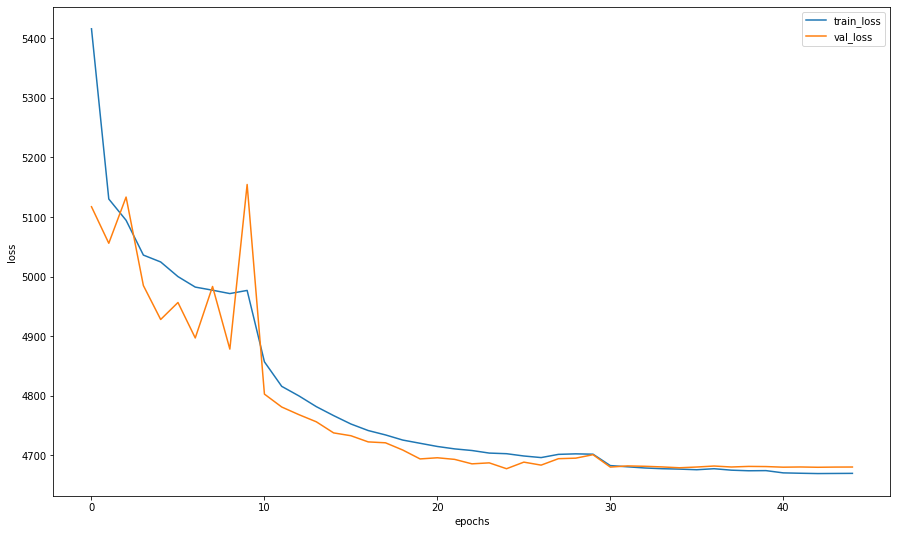

In [ ]:
 make_charts(train_losses, val_losses)

In [ ]:
## сохраню веса модели и лоссы

In [ ]:
torch.save(autoencoder_vae.state_dict(), '/content/gdrive/My Drive/autoencoder_vae.pth')

In [ ]:
train_losses_vae, val_losses_vae = np.array(train_losses), np.array(val_losses)

In [ ]:
np.save('/content/gdrive/My Drive/train_losses_vae', train_losses_vae)
np.save('/content/gdrive/My Drive/val_losses_vae', val_losses_vae)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
## делал при тренировке

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
autoencoder_vae = VAE().to(device)
autoencoder_vae.load_state_dict(torch.load('/content/gdrive/My Drive/autoencoder_vae.pth'
                                            , map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
'''# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
<выведите тут полученные картинки>'''

In [ ]:
## прогоним валидационную выборку и посчитаем среднее значение для латентного вектора

autoencoder_vae.eval()
vector = np.array([0] * (2 * dim_code))

for X_batch in test_loader:
    X_batch = X_batch[0].to(device)

    with torch.set_grad_enabled(False):
        mu, logsigma, X_pred = autoencoder_vae(X_batch)
        mu_sum = mu.cpu().sum(axis=0).numpy()
        logsigma_sum = logsigma.cpu().sum(axis=0).numpy()
        vector = vector + np.concatenate((mu_sum, logsigma_sum))

vector /= test_dataset.data.shape[0]

In [ ]:
vector

array([ 0.12748723,  0.02570778, -6.61343404, -6.43416841])

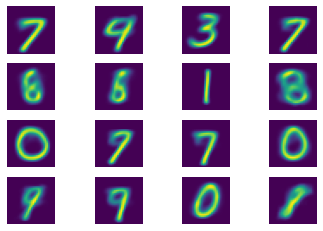

In [ ]:
##
# сгенерируем 16 рандомных векторов размера dim_code
z1 = np.random.randn(16, dim_code) + vector[:2]
z2 = np.random.randn(16, dim_code) * vector[2:].T
z = np.concatenate((z1, z2))
z = torch.from_numpy(z[:, :2]).to(torch.float32)
output = autoencoder_vae.decode(z).view(-1, 1, 28, 28)
## и сгенерируем изображения на их основе
plt.figure()
for i in range(4):
    for j in range(4):
        plt.subplot(4, 4, 4 * i + j + 1)
        plt.imshow(output[4 * i + j][0].detach().numpy())
        plt.axis('off')

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц (##??) выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

In [ ]:
def plot_latent(autoencoder, data, num_batches=50):
    plt.figure(figsize=(16, 8))
    for i, (x, y) in enumerate(data):
        z = autoencoder.encode(x.to(device))
        z = z[0].to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

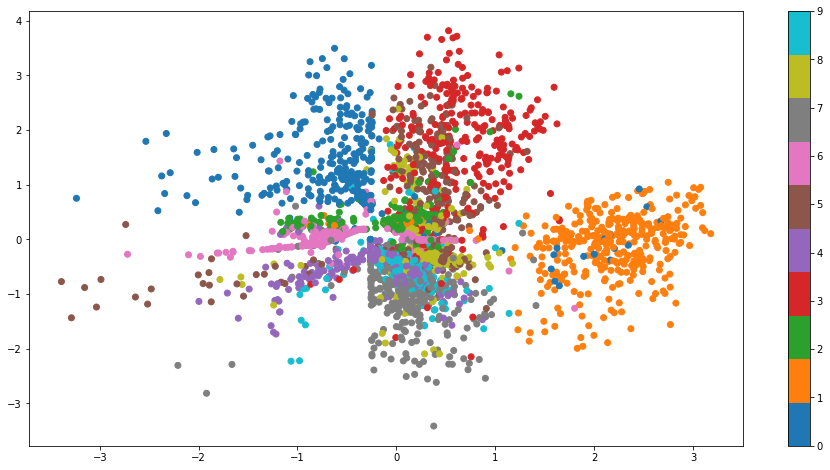

In [ ]:
plot_latent(autoencoder_vae, test_loader, 100)

Что вы думаете о виде латентного представления?

In [ ]:
## до "равномерного" колобка ему, конечно, далеко. 
## Но в чём ленивый студент не увидит подобия нормального распределения!? )

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
## УДАЛИТЬ!!!!!!!!!!
dim_code = 2
class VAE(nn.Module):
    def __init__(self):
        """<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>"""
        
        super(VAE, self).__init__()

        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, dim_code * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim_code, 16),
            nn.ReLU(),
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        """<реализуйте forward проход энкодера
        в качестве возвращаемых переменных -- mu и logsigma>"""
        x = self.flatten(x).float()
        x = self.encoder(x).view(-1, 2, dim_code)
        ## из 4 значений делаем 2 вектора по 2 значения: мю и логвары
        mu = x[:, 0, :] ## первые 2 значения
        logsigma = x[:, 1, :] ## вторые два
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            """<засемплируйте латентный вектор из нормального 
            распределения с параметрами mu и sigma>"""
            ## хотим нормальное распределение (0, 1) сместить так, 
            ## чтобы распределение имело параметры mu и log_var
            std = torch.exp(0.5 * logsigma)  ## стандартное отклонение
            ## генерируем случайную нормальную последовательность 
            ## той же размерности, что и std:
            eps = torch.randn_like(std)
            ## получаем случайные значения смещаясь от средних на eps * std
            sample = mu + (eps * std)
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        """<реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>"""
        reconstruction = self.decoder(z)

        return reconstruction

    def forward(self, x):
        """<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве возвращаемых переменных -- mu, logsigma и reconstruction>"""

        mu, logsigma = self.encode(x)
        # print(f'После энкодера: {mu[0].tolist()}, {logsigma[0].tolist()}')
        sample = self.gaussian_sampler(mu, logsigma)
        # print(f'sample: {sample[0].tolist()}')
        reconstruction = self.decode(sample)

        return mu, logsigma, reconstruction.view(-1, 1, 28, 28)

In [ ]:
dim_code = 2
class CVAE(nn.Module):
    def __init__(self):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        
        super(СVAE, self).__init__()

        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(
            nn.Linear(794, 128),
            nn.ReLU(),
            nn.Linear(128, 16),
            nn.ReLU(),
            nn.Linear(16, dim_code * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(dim_code + 10, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def one_hoted_it(self, class_num):
        one_hot_tensor = torch.zeros(10)
        one_hot_tensor[class_num] = 1
        return one_hot_tensor

    def encode(self, x, class_num):
        '''<реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и класс картинки>'''
        one_hot_tensor = one_hoted_it(class_num)
        x = self.flatten(x).float()
        x = torch.cat((one_hot_tensor, x), 1)
        x = self.encoder(x).view(-1, 2, dim_code)
        ## из 4 значений делаем 2 вектора по 2 значения: мю и логвары
        mu = x[:, 0, :] ## первые 2 значения
        logsigma = x[:, 1, :] ## вторые два      
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>
        
        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>